# Template for analyzing the CLM5-PPE
- Updated August 11, 2021
- Daniel Kennedy, djk2120@ucar.edu

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import statsmodels.api as sm
import seaborn as sns

In [2]:
### import some analysis functions we wrote for this project
import sys ; sys.path.append("..")
from ppe_analysis.analysis import *

## spin up some extra cores on CASPER

In [99]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='25GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    project='P93300641', # Input your project ID here
    walltime='01:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34686 instead
  http_address["port"], self.http_server.port


In [100]:
client.cluster

## A few useful functions

In [75]:
def get_files(exp,key,tape):
    top='/glade/campaign/asp/djk2120/PPEn11/'
    d=top+exp+'/hist/'

    df=pd.read_csv(key)
    keys = df.key.values
    files=[glob.glob(d+'*'+key+'*.'+tape+'.*')[0] for key in keys]
    appends={'key':keys,'param':df.param.values,'minmax':df.minmax.values}

    return files,appends

In [74]:
def get_ds(files,dvs,appends={}):
    def preprocess(ds):
        return ds[dvs]
    ds = xr.open_mfdataset(files,combine='nested',concat_dim='ens',
                           parallel=True,
                           preprocess=preprocess)
    f=files[0]
    htape=f.split('clm2')[1][1:3]

    #fix up time dimension
    if (htape=='h0')|(htape=='h1'):
        yr0=str(ds['time.year'][0].values)
        nt=len(ds.time)
        ds['time'] = xr.cftime_range(yr0,periods=nt,freq='MS',calendar='noleap') #fix time bug

    #add in some extra variables
    ds0 = xr.open_dataset(files[0])
    extras = ['grid1d_lat','grid1d_lon']
    for extra in extras:
        ds[extra]=ds0[extra]
    la=xr.open_dataset('./sparsegrid_landarea.nc').landarea
    ds['la']=la

    for append in appends:
        ds[append]=xr.DataArray(appends[append],dims='ens')
        
    return ds

In [104]:
cfs={'GPP':[24*60*60,1e-9]}

In [117]:
def amean(da):
    v=da.name
    if v in cfs:
        cf1,cf2=cfs[v]
    else:
        cf1=1/365
    dpm=ds['time.daysinmonth']
    x=cf1*(dpm*da).groupby('time.year').sum().compute()
    x.name=v
    return x

In [114]:
def gmean(da,la):
    if v in cfs:
        cf1,cf2=cfs[v]
    else:
        cf2=1/la.sum()
    x=cf2*(da*la).sum(dim='gridcell').compute()
    x.name=v
    return x

In [126]:
key='/glade/campaign/asp/djk2120/PPEn11/csvs/surv.csv'
tape='h0'
dvs=['TLAI','GPP']
exps=['CTL2010','C285','C867','AF1855','AF2095','NDEP']
dsets={}
for exp in exps:
    print(exp)
    files,appends=get_files(exp,key,tape)
    dsets[exp]=get_ds(files,dvs,appends)

CTL2010
C285
C867
AF1855
AF2095
NDEP


In [128]:
v='GPP'
x={exp:amean(gmean(dsets[exp][v],ds.la)).mean(dim='year') for exp in exps}


In [151]:
nens=len(x['CTL2010'])
data={'GPP':np.concatenate([x[exp].values for exp in x]),
      'exp':np.concatenate([np.tile(exp,nens) for exp in x])}
df=pd.DataFrame(data)

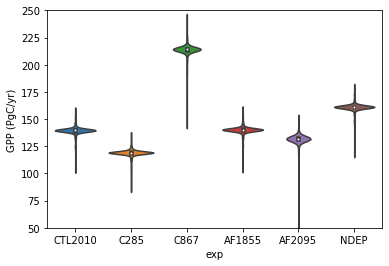

In [187]:
sns.violinplot(data=df,y='GPP',x='exp')
plt.ylabel('GPP (PgC/yr)')
plt.ylim([50,250]);

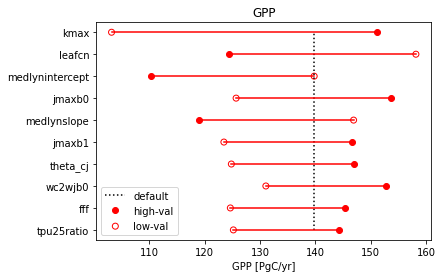

In [192]:
ee='CTL2010'
da=x[ee]
da.attrs={'units':'PgC/yr'}
rank_plot(da,dsets[ee],10)


In [199]:
ee='CTL2010'
ds=dsets[ee]
ix=(ds.param=='kmax')&(ds.minmax=='min')

gpp1=amean(ds.GPP.isel(ens=ix)).mean(dim='year')


KeyboardInterrupt: 

In [ ]:
gpp0=ds.GPP.isel(ens=0)

In [186]:
## AF2095-OAAT0058 looks buggy
ee='AF2095'
ix=x[ee].argmin()
print(dsets[ee].key[ix].values,':',dsets[ee].param[ix].values,'-',dsets[ee].minmax[ix].values)
xx={exp:np.round((x[exp][ix]/x[exp][0]).values,2) for exp in exps}
xx

OAAT0058 : csol_sand - min


{'CTL2010': 1.0,
 'C285': 1.0,
 'C867': 1.0,
 'AF1855': 1.0,
 'AF2095': 0.08,
 'NDEP': 1.0}